In [1]:
# uses conda environment c14

import pandas as pd
import numpy as np
from numpy import asarray
from pathlib import Path

from iosacal.core import RadiocarbonDetermination as R


from util import calcDelR, make_regions
from util import iosacal_util as ios

PROJECT_ROOT = Path.cwd().parents[1]
data_dir = PROJECT_ROOT / "ws/data/"
print('done')

done


In [2]:
xls = pd.ExcelFile('IOSA_v_Calib_Terrestrial.xlsx', engine='openpyxl')
df = pd.read_excel(xls, 'Sheet1', header=0)

# ######## NOTE: THIS IS BRITTLE.  MAKE A COLUMN IN YOUR SPREADSHEET #######
# ######## THAT LABELS WHICH DATA ARE MARINE VS TERRESTRIAL ################
########## IN EXAMPLE NOTEBOOK (IOSA_v_Calib_Terrestrial.xlsx), ############
########## ALL SAMPLES ARE TERRESTRIAL. ################
df['ismarine'] = df['Dated facies'].map(lambda x: 1 if 'marine' in x else 0)

# Comment this in to test whether the reservoir correction works
# df['ismarine'] = np.ones(len(df))


# Calculate Delta R

In [3]:
df_R = pd.read_excel('delta_R_calibration.xlsx')
df_R.head(2)

# instantiate make_regions class & visualize to sanity check.
regionMaker = make_regions(df_R)
    
# add 'site' columns to df and df_R
df, df_R = [regionMaker.apply_boxes_to_df(d) for d in [df, df_R]]
print('done')

done


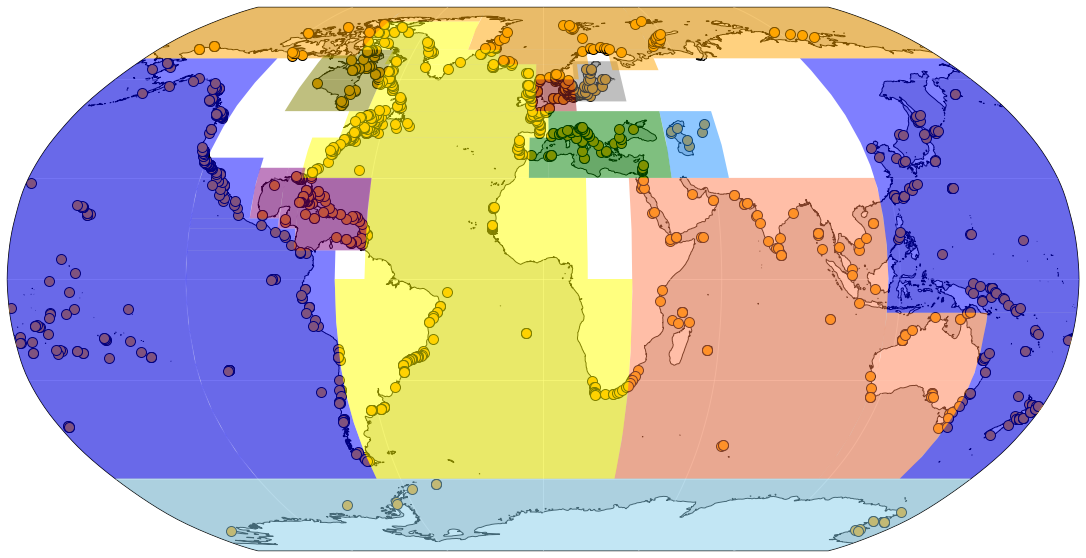

In [4]:
save=True
regionMaker.plot_polygons(save=save)


In [5]:
##### 'n' SPECIFIES HOW MANY OF THE CLOSEST MARINE RESERVOIR VALUES ####
#####  TO EACH SAMPLE ARE AVERAGED, WEIGHTED BY INVERSE DISTANCE ###############
#####  MAXDIST SPECIFIES THE MAXIMUM GREAT-CIRCLE DISTANCE WITHIN ###############
#####  WHICH TO SELECT RESERVOIR VALUES ###############

nclosest=10000
maxdist=200

# Change this to 'True' if you want to see 
# how many reservoir data are within maxdist of each sample
text = False
meanname = 'ΔR (14C a)'
sigmaname = 'Reservoir age uncertainty (14C a)'


df[meanname] = df.apply(lambda r: calcDelR(df_R, 
                                           r, 
                                           nclosest=nclosest, 
                                           maxdist=maxdist).getMu(text=text), axis=1)
df[sigmaname] = df.apply(lambda r: calcDelR(df_R, 
                                            r, 
                                            nclosest=nclosest,
                                            maxdist=maxdist).getUncert(), axis=1)


print('done')

done


# Calibrate Radiocarbon ages 

In [6]:
for i, r in df.iterrows():
    
    age =  r['Corrected age       (14C a BP)'] + r['ΔR (14C a)']
    age_onesig = np.sqrt(r['Corrected age uncertainty (14C a)']**2 +
                         r['Reservoir age uncertainty (14C a)']**2) #+
                             # r['Bulk error (14C a)']         
        
    ##### NOTE THAT THIS CODE CURRENTLY DOES NOT ADD BULK UNCERTAINTY.  
    ##### COMMENT IN THE LINE ABOVE TO INCLUDE A SPREADSHEET COLUMN 
    ##### FOR BULK UNCERTAINTY 

    if age < 0:  
        t1 = "This code cannot process dates younger than 1950."
        t2 = "Please remove those dates and rerun."
        raise ValueError(t1 + t2)


    # Calculate radiocarbon determination
    cr = R(age, age_onesig, r['Sample ID'])

    # Choose calibration curve.  
    # NOTE: you can add any .14c file (e.g. Brendryen 2020's normarine18)
    # by searching for 'intcal20.14c', navigating to the directory where 
    # it is stored, and adding the new .14c file.
    calib = 'intcal20'
    if r.ismarine:
        calib = 'marine20'
    elif (r.Latitude < 0):
        calib = 'shcal20'


    cal =  cr.calibrate(calib)

    CImean = ios.calc_median(cal)
    CI95high = cal.intervals[95][0].from_year
    CI95low = cal.intervals[95][-1].to_year

    
    df.loc[i, 'Age                   (cal a BP)'] = CImean
    df.loc[i, 'Age 2σ Uncertainty +              (cal a)'] = CI95high - CImean 
    df.loc[i, 'Age 2σ Uncertainty -              (cal a)'] = CImean - CI95low


    if i%1 == 0:
        
        print(f'----{i}----')
        print('delta r = ', r['ΔR (14C a)'])
        print('delta r uncertainty = ',  r['Reservoir age uncertainty (14C a)'])
        print('corrected age = ', round(age, 2))
        print('c14 age uncertainty = ', round(age_onesig, 2))
        print('Calibrated mean age = ', round(CImean, 2))
        print('Calibrated midpoint age = ',  round((CI95high + CI95low)/2, 2))
        print('calibrated age uncertainty (-,+) =', round(CImean - CI95low, 2), 
                                              round(CI95high - CImean, 2)
             )

        print('--------') 
        print('     ')

print('done')

----0----
delta r =  0
delta r uncertainty =  0
corrected age =  4667.01
c14 age uncertainty =  267.76
Calibrated mean age =  5333.0
Calibrated midpoint age =  5286.0
calibrated age uncertainty (-,+) = 747.0 653.0
--------
     
----1----
delta r =  0
delta r uncertainty =  0
corrected age =  2387.01
c14 age uncertainty =  207.35
Calibrated mean age =  2438.0
Calibrated midpoint age =  2404.5
calibrated age uncertainty (-,+) = 548.0 481.0
--------
     
----2----
delta r =  0
delta r uncertainty =  0
corrected age =  3187.01
c14 age uncertainty =  249.99
Calibrated mean age =  3398.0
Calibrated midpoint age =  3418.0
calibrated age uncertainty (-,+) = 623.0 663.0
--------
     
----3----
delta r =  0
delta r uncertainty =  0
corrected age =  4432.0
c14 age uncertainty =  107.34
Calibrated mean age =  5072.0
Calibrated midpoint age =  5134.0
calibrated age uncertainty (-,+) = 242.0 366.0
--------
     
----4----
delta r =  0
delta r uncertainty =  0
corrected age =  4245.0
c14 age uncer

In [11]:

# choose your own save path
filename = "IOSA_v_Calib_Terrestrial_updated"
#savepath = f'/Users/rogercreel/Desktop/{filename}.xlsx'
savepath = f"calibrated/{filename}.xlsx"

df.to_excel(savepath)